# Big Data

### Challenge

#### Using Dask for Supervised Machine Learning

- David Booker-Earley
- 7/3/2020

---

# Introduction & Data Overview

In this project, two ML models will be trained on a simple dataset to predict two classes from a previous multiclass classification project; results will be briefly compared using ROC-AUC scores.
* The dataset is the **digits** dataset, which is available from **sklearn**'s `datasets` library.
* This dataset contain 1797 samples of written digits. 

**The goal is to correctly identify digits 0 and 1.**

## Setup

In [1]:
!pip install --upgrade "dask[complete]"

Requirement already up-to-date: dask[complete] in /opt/conda/lib/python3.7/site-packages (2.20.0)


In [2]:
!pip install dask-ml

In [3]:
import warnings
warnings.filterwarnings("ignore")


## imports to load and (pre-)process data
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
from sklearn.datasets import load_digits
import dask.dataframe as dd
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import time


## imports for ML models and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
# from dask_ml.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [4]:
## Instantiate Dask dashboard to monitor code execution
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:38741 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


## Load Data

In [5]:
## Load data into Dask dataframe via Pandas
df = load_digits(n_class=2, as_frame=True).frame
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 65 columns):
pixel_0_0    360 non-null float64
pixel_0_1    360 non-null float64
pixel_0_2    360 non-null float64
pixel_0_3    360 non-null float64
pixel_0_4    360 non-null float64
pixel_0_5    360 non-null float64
pixel_0_6    360 non-null float64
pixel_0_7    360 non-null float64
pixel_1_0    360 non-null float64
pixel_1_1    360 non-null float64
pixel_1_2    360 non-null float64
pixel_1_3    360 non-null float64
pixel_1_4    360 non-null float64
pixel_1_5    360 non-null float64
pixel_1_6    360 non-null float64
pixel_1_7    360 non-null float64
pixel_2_0    360 non-null float64
pixel_2_1    360 non-null float64
pixel_2_2    360 non-null float64
pixel_2_3    360 non-null float64
pixel_2_4    360 non-null float64
pixel_2_5    360 non-null float64
pixel_2_6    360 non-null float64
pixel_2_7    360 non-null float64
pixel_3_0    360 non-null float64
pixel_3_1    360 non-null float64
pixel_3_2  

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0,1
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0


In [6]:
## Load data into Dask dataframe via Pandas
digits = dd.from_pandas(df, npartitions=2)
digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0,1
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0,0


## Exploratory Data Analysis

In [7]:
digits.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 65 entries, pixel_0_0 to target
dtypes: float64(64), int64(1)

In [29]:
## Are there any missing values?
any_nans = digits.isna().any(axis=None).compute()

print("Are there any missing (NULL or NAN) values anywhere?")
print(any_nans.any())

Are there any missing (NULL or NAN) values anywhere?
False


In [8]:
print(f"There are {digits.drop(columns=['target']).shape[1]} features")

There are 64 features


In [9]:
## Before using compute()
print(f"Number of rows in feature set: {digits.shape[0]}")

Number of rows in feature set: Delayed('int-d3cb6c61-3405-4bbb-a550-76c22e080602')


In [10]:
## With compute()
print(f"Number of rows in feature set: {digits.shape[0].compute()}")

Number of rows in feature set: 360


In [11]:
## Before using compute()
digits.target.value_counts()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: target, dtype: int64
Dask Name: value-counts-agg, 7 tasks

In [12]:
## With compute()
digits.target.value_counts().compute().sort_index()

0    178
1    182
Name: target, dtype: int64

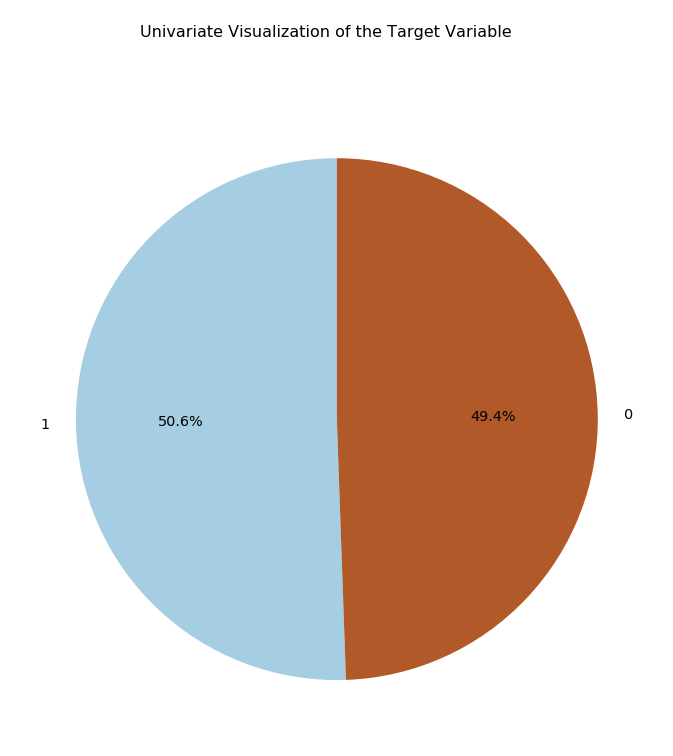

In [13]:
## Univariate Visualization

## Visualize the "spread" of Categorical Variables

# Pie Chart of the Target
plt.figure(figsize=(12,12))
plt.suptitle(f"""
Univariate Visualization of the Target Variable
""", fontsize=16)

textprops = {'size': 'x-large',
             'color': 'k',}

(digits.target.value_counts().compute()
 .plot
 .pie(autopct='%1.1f%%',
     startangle=90,
     textprops=textprops,
     cmap='Paired'))

plt.xlabel('')
plt.ylabel('')

plt.show();

Each class seems to be fairly evenly represented; thus, this is a balanced dataset.

## Split Data

A random state value will be used to ensure repeatable results.

In [14]:
# X contains the feature set, y contains the target labels.
X = digits.drop(columns=['target'])
y = digits.target

# Preprocess dataset. Split into a set for training & a set for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.2,
    random_state=111,
)

In [15]:
# Inspect the results.
print(f"{X_train.shape[0].compute()} observations in training set")
print(f"{X_test.shape[0].compute()} observations in testing set")

79 observations in training set
281 observations in testing set


In [16]:
print(type(X))
X.compute().head()

<class 'dask.dataframe.core.DataFrame'>


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0


In [17]:
print(type(y))
y.compute().head()

<class 'dask.dataframe.core.Series'>


0    0
1    1
2    0
3    1
4    0
Name: target, dtype: int64

In [18]:
print(type(X_train))
X_train.compute().head()

<class 'dask.dataframe.core.DataFrame'>


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,11.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,14.0,6.0,0.0,0.0
12,0.0,0.0,2.0,14.0,15.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,11.0,13.0,4.0,0.0,0.0
23,0.0,0.0,1.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,3.0,10.0,16.0,12.0,1.0,0.0
28,0.0,0.0,12.0,9.0,12.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,12.0,12.0,2.0,0.0,0.0


In [19]:
print(type(X_test))
X_test.compute().head()

<class 'dask.dataframe.core.DataFrame'>


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,1.0,9.0,15.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10.0,13.0,3.0,0.0,0.0
3,0.0,0.0,0.0,0.0,14.0,13.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,13.0,16.0,1.0,0.0
4,0.0,0.0,3.0,13.0,11.0,7.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,12.0,13.0,4.0,0.0,0.0
5,0.0,0.0,0.0,2.0,16.0,16.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,12.0,15.0,4.0,0.0


## Random Forest Model

In [20]:
t_start = time.clock()


## Input Parameters
param_grid = {
    'max_depth': [2, 6, 10],
    'n_jobs': [-1],
}


## Instantiate model. Prform Cross Validation to tune params
model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    verbose=10,
    cv=3,
    scoring='roc_auc',
)
# Parallelize model fitting by using Dask as the backend of joblib
with joblib.parallel_backend('dask'):
    model.fit(X_train.compute(), y_train.compute())


## Make predictions
pred_test = model.predict(X_test.values.compute())


## Get Elapsed Time
t = time.clock() - t_start

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    7.5s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    7.5s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    7.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    7.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    7.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.0s finished


In [21]:
print("** Random Forest Classifier **")
if t >= 60**2:
    print(f"Runtime: {t/60**2 :0.1f} hours")
elif t >= 60.0:
    print(f"Runtime: {t/60 :0.1f} minutes")
else:
  print(f"Runtime: {t :0.4f} seconds")
print(f"Best parameters: {model.best_params_}")
print('.'*25)
print("Area Under the Receiver Operating Characteristic Curve".title())
print(f"Test score: {roc_auc_score(pred_test, y_test.values.compute())}")

** Random Forest Classifier **
Runtime: 2.7609 seconds
Best parameters: {'max_depth': 2, 'n_jobs': -1}
.........................
Area Under The Receiver Operating Characteristic Curve
Test score: 0.9966216216216216


## Logistic Regression Model

In [22]:
t_start = time.clock()


## Input Parameters
param_grid = {
    'max_iter': [50, 100, 150],
    'n_jobs': [-1],
}


## Instantiate model. Prform Cross Validation to tune params
model = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000),
    param_grid=param_grid,
    n_jobs=-1,
    verbose=10,
    cv=3,
    scoring='roc_auc',
)
# Parallelize model fitting by using Dask as the backend of joblib
with joblib.parallel_backend('dask'):
    model.fit(X_train.compute(), y_train.compute())


## Make predictions
pred_test = model.predict(X_test.values.compute())


## Get Elapsed Time
t = time.clock() - t_start

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s finished


In [23]:
print("** Logistic Regression **")
if t >= 60**2:
    print(f"Runtime: {t/60**2 :0.1f} hours")
elif t >= 60.0:
    print(f"Runtime: {t/60 :0.1f} minutes")
else:
  print(f"Runtime: {t :0.4f} seconds")
print(f"Best parameters: {model.best_params_}")
print('.'*25)
print("Area Under the Receiver Operating Characteristic Curve".title())
print(f"Test score: {roc_auc_score(pred_test, y_test.values.compute())}")

** Logistic Regression **
Runtime: 0.3660 seconds
Best parameters: {'max_iter': 50, 'n_jobs': -1}
.........................
Area Under The Receiver Operating Characteristic Curve
Test score: 1.0


## Compare Results

The Logistic Regression model performed the best based on its higher ROC-AUC score.

It also ran for less than 1 second for the same number of fits tried in the Random Forest model.

Based on their high scores, it may be fairly easy for the models to identify patterns and make sufficient predictions for this project. However, due to both the small sample size and overall nature of this dataset, it is unclear if these models would perform as well on new, previously unseen data.

In [24]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
